G05: Jakober, Winkler, Matzinger, Salzmann

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchsummary import summary

import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline
random.seed(123)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


In [3]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,                    
    transform = ToTensor(), 
    download = True,            
)

In [4]:
dataloader = DataLoader(train_data, 60000, shuffle=False, num_workers=2)
X, _ = next(iter(dataloader))
mean, std = torch.mean(X).item(), torch.std(X).item()

In [5]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,                    
    transform = Compose([ToTensor(), Normalize(mean, std)]),
    download = True,
)

test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = Compose([ToTensor(), Normalize(mean, std)]),
    download = True
)

In [6]:
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

## Define the architecture

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(28*28*32, 10)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = F.tanh(self.conv3(x))
        x = F.tanh(self.conv4(x))
        x = F.tanh(self.conv5(x))
        return self.fc(self.flatten(x))

In [8]:
summary(CNN())

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─Conv2d: 1-3                            9,248
├─Conv2d: 1-4                            9,248
├─Conv2d: 1-5                            9,248
├─Flatten: 1-6                           --
├─Linear: 1-7                            250,890
Total params: 288,202
Trainable params: 288,202
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─Conv2d: 1-3                            9,248
├─Conv2d: 1-4                            9,248
├─Conv2d: 1-5                            9,248
├─Flatten: 1-6                           --
├─Linear: 1-7                            250,890
Total params: 288,202
Trainable params: 288,202
Non-trainable params: 0

In [9]:
def run_epoch(model, dataloader, optimizer, criterion, train=True):
    """
    Runs one epoch for training or validation.
    """
    epoch_loss = 0
    correct = 0
    total_samples = len(dataloader.dataset)

    if train:
        model.train()
    else:
        model.eval()

    for X, y in tqdm(dataloader, desc=f'{"Train" if train else "Val"} Epoch'):
        X, y = X.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            output = model(X)
            loss = criterion(output, y)

        epoch_loss += loss.item()
        _, y_pred = torch.max(output, dim=1)
        correct += torch.sum(y_pred == y).item()

        if train:
            loss.backward()
            optimizer.step()

    avg_loss = epoch_loss / len(dataloader)
    accuracy = correct / total_samples

    return avg_loss, accuracy

def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    """
    Trains and evaluates the model for n_epochs.
    """
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    for epoch in range(n_epochs):

        print(f'\nEpoch {epoch+1}/{n_epochs}')
        print('----------')

        train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, train=True)
        val_loss, val_acc = run_epoch(model, val_loader, optimizer, criterion, train=False)
            
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        epoch_train_accs.append(train_acc)
        epoch_val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}\nVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    
    return epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs

In [10]:
def eval(model, test_loader, criterion):
    """
    Evaluates the model on the test set.
    """
    epoch_loss = 0
    correct = 0
    y_preds = []

    model.eval()
    with torch.no_grad():
        for X_test, y_test in tqdm(test_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            output = model(X_test)
            loss = criterion(output, y_test)
            epoch_loss += loss.item()

            _, y_pred = torch.max(output, dim=1)
            y_preds.append(y_pred.cpu())
            correct += torch.sum(y_pred == y_test).item()
        
        epoch_loss /= len(test_loader)
        accuracy = correct / len(test_loader.dataset)
    
    y_preds = torch.cat(y_preds).numpy()

    return epoch_loss, accuracy, y_preds

In [11]:
def plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6), layout='tight')

    ax[0].plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_xticks(range(1, n_epochs+1))
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, n_epochs + 1), train_acc, label='Training Accuracy')
    ax[1].plot(range(1, n_epochs + 1), val_acc, label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_xticks(range(1, n_epochs+1))
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0,1)
    ax[1].grid()
    ax[1].legend()

    fig.suptitle('Train/Val Losses and Accuracies')
    plt.show()

In [12]:
results = {}

## Baseline


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.23it/s]


Train Loss: 0.4791, Train Accuracy: 0.8301
Val Loss: 0.3858, Val Accuracy: 0.8618

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 66.17it/s]


Train Loss: 0.3355, Train Accuracy: 0.8800
Val Loss: 0.3246, Val Accuracy: 0.8890

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.57it/s]


Train Loss: 0.2848, Train Accuracy: 0.8989
Val Loss: 0.3023, Val Accuracy: 0.8953

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 73.77it/s]


Train Loss: 0.2462, Train Accuracy: 0.9117
Val Loss: 0.2821, Val Accuracy: 0.9030

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.78it/s]


Train Loss: 0.2168, Train Accuracy: 0.9223
Val Loss: 0.2960, Val Accuracy: 0.8983

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.88it/s]


Train Loss: 0.1972, Train Accuracy: 0.9299
Val Loss: 0.3066, Val Accuracy: 0.8966

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 75.98it/s]


Train Loss: 0.1732, Train Accuracy: 0.9371
Val Loss: 0.2973, Val Accuracy: 0.9020

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.33it/s]


Train Loss: 0.1605, Train Accuracy: 0.9420
Val Loss: 0.3258, Val Accuracy: 0.8969

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.95it/s]


Train Loss: 0.1498, Train Accuracy: 0.9455
Val Loss: 0.3418, Val Accuracy: 0.8965

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.79it/s]


Train Loss: 0.1303, Train Accuracy: 0.9525
Val Loss: 0.3529, Val Accuracy: 0.9040


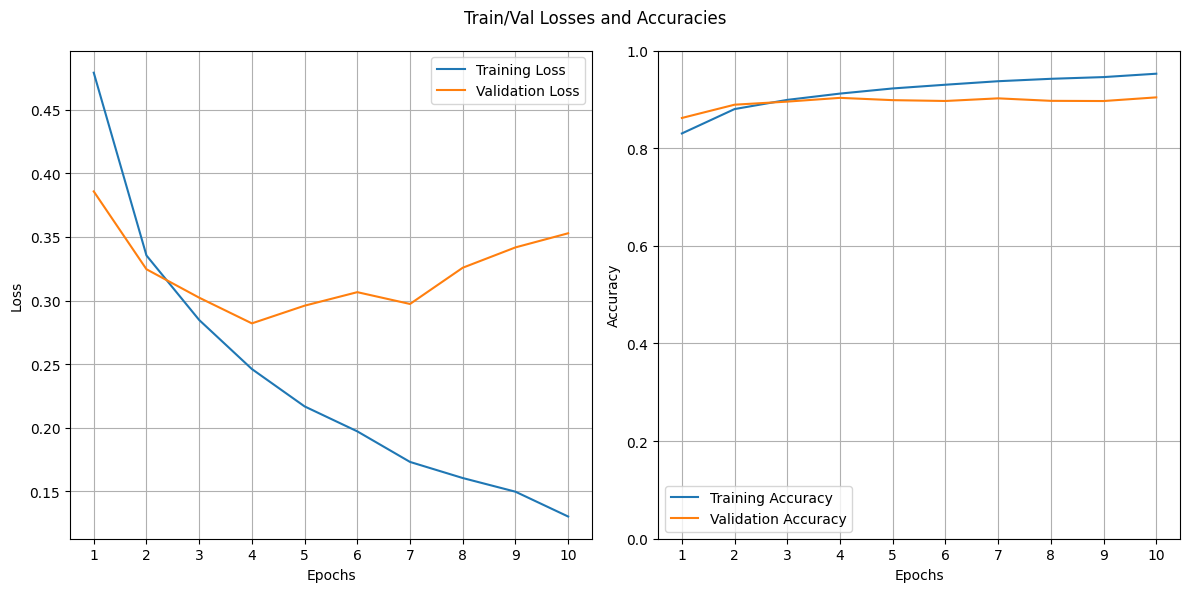

In [13]:
n_epochs = 10

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results['baseline'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]
plot_loss_curve(n_epochs, epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs)

## Different Weights & Zero Bias

In [14]:
def init_weights_by_name(name):
    def initializer(model):
        if isinstance(model, (nn.Conv2d, nn.Linear)):
            if name == 'zero':
                nn.init.constant_(model.weight, 0.0)
            elif name == 'normal':
                nn.init.normal_(model.weight, mean=0.0, std=1.0)
            elif name == 'uniform':
                nn.init.uniform_(model.weight, a=-0.5, b=0.5)
            elif name == 'xavier_tanh':
                gain = nn.init.calculate_gain('tanh')
                nn.init.xavier_uniform_(model.weight, gain=gain)
            elif name == 'kaiming_relu':
                nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
            else:
                raise ValueError(f'Unknown init method: {name}')

            if model.bias is not None:
                nn.init.constant_(model.bias, 0.0)
                
    return initializer

In [15]:
methods = ['zero', 'normal', 'uniform', 'xavier_tanh', 'kaiming_relu']

In [16]:
n_epochs = 10

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False)

for method in methods:
    model = CNN()
    model.apply(init_weights_by_name(method))
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
    results[method] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.30it/s]


Train Loss: 2.3027, Train Accuracy: 0.0986
Val Loss: 2.3027, Val Accuracy: 0.0976

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 73.00it/s]


Train Loss: 2.3027, Train Accuracy: 0.0979
Val Loss: 2.3027, Val Accuracy: 0.0967

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.28it/s]


Train Loss: 2.3027, Train Accuracy: 0.0991
Val Loss: 2.3027, Val Accuracy: 0.0976

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.71it/s]


Train Loss: 2.3027, Train Accuracy: 0.0985
Val Loss: 2.3027, Val Accuracy: 0.0987

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.88it/s]


Train Loss: 2.3027, Train Accuracy: 0.0977
Val Loss: 2.3027, Val Accuracy: 0.0976

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.33it/s]


Train Loss: 2.3027, Train Accuracy: 0.0960
Val Loss: 2.3027, Val Accuracy: 0.0967

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 83.51it/s]


Train Loss: 2.3027, Train Accuracy: 0.0982
Val Loss: 2.3028, Val Accuracy: 0.0966

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 83.27it/s]


Train Loss: 2.3027, Train Accuracy: 0.0981
Val Loss: 2.3027, Val Accuracy: 0.0976

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 83.73it/s]


Train Loss: 2.3027, Train Accuracy: 0.0998
Val Loss: 2.3027, Val Accuracy: 0.0966

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.73it/s]


Train Loss: 2.3027, Train Accuracy: 0.0978
Val Loss: 2.3026, Val Accuracy: 0.1019

Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.90it/s]


Train Loss: 68.7699, Train Accuracy: 0.5534
Val Loss: 49.0177, Val Accuracy: 0.6549

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 74.21it/s]


Train Loss: 42.8881, Train Accuracy: 0.6868
Val Loss: 39.4854, Val Accuracy: 0.7012

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.15it/s]


Train Loss: 35.6773, Train Accuracy: 0.7208
Val Loss: 33.4063, Val Accuracy: 0.7344

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.15it/s]


Train Loss: 29.8176, Train Accuracy: 0.7454
Val Loss: 29.9921, Val Accuracy: 0.7527

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 81.01it/s]


Train Loss: 26.7695, Train Accuracy: 0.7545
Val Loss: 26.5928, Val Accuracy: 0.7600

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 77.20it/s]


Train Loss: 23.9800, Train Accuracy: 0.7654
Val Loss: 24.2949, Val Accuracy: 0.7664

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.79it/s]


Train Loss: 21.9397, Train Accuracy: 0.7722
Val Loss: 21.7411, Val Accuracy: 0.7702

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.74it/s]


Train Loss: 20.4197, Train Accuracy: 0.7742
Val Loss: 20.8587, Val Accuracy: 0.7706

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 81.86it/s]


Train Loss: 18.7268, Train Accuracy: 0.7751
Val Loss: 19.7788, Val Accuracy: 0.7707

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.55it/s]


Train Loss: 17.8262, Train Accuracy: 0.7752
Val Loss: 18.9336, Val Accuracy: 0.7697

Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 63.69it/s]


Train Loss: 8.6772, Train Accuracy: 0.7128
Val Loss: 5.5395, Val Accuracy: 0.7722

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 79.74it/s]


Train Loss: 4.7044, Train Accuracy: 0.7902
Val Loss: 4.5846, Val Accuracy: 0.7943

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 81.87it/s]


Train Loss: 3.8684, Train Accuracy: 0.8108
Val Loss: 4.0789, Val Accuracy: 0.8055

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 80.51it/s]


Train Loss: 3.3031, Train Accuracy: 0.8247
Val Loss: 3.6887, Val Accuracy: 0.8170

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 66.25it/s]


Train Loss: 2.9221, Train Accuracy: 0.8345
Val Loss: 3.8558, Val Accuracy: 0.8059

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 72.17it/s]


Train Loss: 2.6620, Train Accuracy: 0.8407
Val Loss: 3.9185, Val Accuracy: 0.8088

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.11it/s]


Train Loss: 2.5524, Train Accuracy: 0.8442
Val Loss: 3.9725, Val Accuracy: 0.8154

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.80it/s]


Train Loss: 2.4127, Train Accuracy: 0.8497
Val Loss: 3.4355, Val Accuracy: 0.8353

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 77.59it/s]


Train Loss: 2.2410, Train Accuracy: 0.8565
Val Loss: 2.9595, Val Accuracy: 0.8445

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 75.86it/s]


Train Loss: 2.1614, Train Accuracy: 0.8587
Val Loss: 2.8807, Val Accuracy: 0.8395

Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 72.50it/s]


Train Loss: 0.5578, Train Accuracy: 0.8281
Val Loss: 0.3647, Val Accuracy: 0.8765

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.31it/s]


Train Loss: 0.3429, Train Accuracy: 0.8858
Val Loss: 0.3305, Val Accuracy: 0.8914

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 78.22it/s]


Train Loss: 0.2857, Train Accuracy: 0.9046
Val Loss: 0.3991, Val Accuracy: 0.8850

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


Train Loss: 0.2340, Train Accuracy: 0.9216
Val Loss: 0.4287, Val Accuracy: 0.8789

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 81.76it/s]


Train Loss: 0.1949, Train Accuracy: 0.9335
Val Loss: 0.4435, Val Accuracy: 0.8887

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.96it/s]


Train Loss: 0.1879, Train Accuracy: 0.9391
Val Loss: 0.4274, Val Accuracy: 0.8959

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.03it/s]


Train Loss: 0.1607, Train Accuracy: 0.9474
Val Loss: 0.4442, Val Accuracy: 0.8958

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 76.08it/s]


Train Loss: 0.1422, Train Accuracy: 0.9546
Val Loss: 0.5471, Val Accuracy: 0.8897

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.17it/s]


Train Loss: 0.1389, Train Accuracy: 0.9557
Val Loss: 0.6021, Val Accuracy: 0.8868

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 79.99it/s]


Train Loss: 0.1313, Train Accuracy: 0.9587
Val Loss: 0.5739, Val Accuracy: 0.8975

Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 88.14it/s]


Train Loss: 0.5043, Train Accuracy: 0.8356
Val Loss: 0.3877, Val Accuracy: 0.8710

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.22it/s]


Train Loss: 0.3054, Train Accuracy: 0.8950
Val Loss: 0.3597, Val Accuracy: 0.8823

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.95it/s]


Train Loss: 0.2297, Train Accuracy: 0.9207
Val Loss: 0.3514, Val Accuracy: 0.8962

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 83.93it/s]


Train Loss: 0.2007, Train Accuracy: 0.9323
Val Loss: 0.4347, Val Accuracy: 0.8855

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 88.89it/s]


Train Loss: 0.1654, Train Accuracy: 0.9439
Val Loss: 0.4038, Val Accuracy: 0.8951

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 81.85it/s]


Train Loss: 0.1550, Train Accuracy: 0.9478
Val Loss: 0.4769, Val Accuracy: 0.8865

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.04it/s]


Train Loss: 0.1427, Train Accuracy: 0.9533
Val Loss: 0.4963, Val Accuracy: 0.8866

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.51it/s]


Train Loss: 0.1335, Train Accuracy: 0.9570
Val Loss: 0.4991, Val Accuracy: 0.8954

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.12it/s]


Train Loss: 0.1129, Train Accuracy: 0.9635
Val Loss: 0.5501, Val Accuracy: 0.8954

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 73.69it/s]

Train Loss: 0.1122, Train Accuracy: 0.9647
Val Loss: 0.5697, Val Accuracy: 0.8963


In [49]:
def plot_loss_curves(n_epochs, results):
    
    fig, ax = plt.subplots(2, 2, figsize=(24,18))
    
    line_styles = ['-', '--', '-.', ':']
    colors = plt.cm.tab10.colors
    
    for i, (name, metric) in enumerate(results.items()):

        style = random.choice(line_styles)
        color = colors[i % len(colors)]

        x = range(1, n_epochs + 1)

        ax[0, 0].plot(x, metric[0], linestyle=style, color=color, label=name)
        ax[0, 0].set_title('Train Loss')
        ax[0, 0].set_ylabel('Loss')

        ax[0, 1].plot(x, metric[1], linestyle=style, color=color, label=name)
        ax[0, 1].set_title('Validation Loss')
        ax[0, 1].set_ylabel('Loss')
        
        ax[1, 0].plot(x, metric[2], linestyle=style, color=color, label=name)
        ax[1, 0].set_title('Train Accuracy')
        ax[1, 0].set_ylabel('Accuracy')
        ax[1, 0].set_ylim(0, 1)

        ax[1, 1].plot(x, metric[3], linestyle=style, color=color, label=name)
        ax[1, 1].set_title('Validation Accuracy')
        ax[1, 1].set_ylabel('Accuracy')
        ax[1, 1].set_ylim(0, 1)
        
    for axes in ax.flat:
        axes.set_xlabel('Epochs')
        axes.set_xticks(range(1, n_epochs+1))
        axes.grid()
        axes.legend()

    fig.suptitle('Train/Val Losses and Accuracies', fontsize=18)
    plt.show()

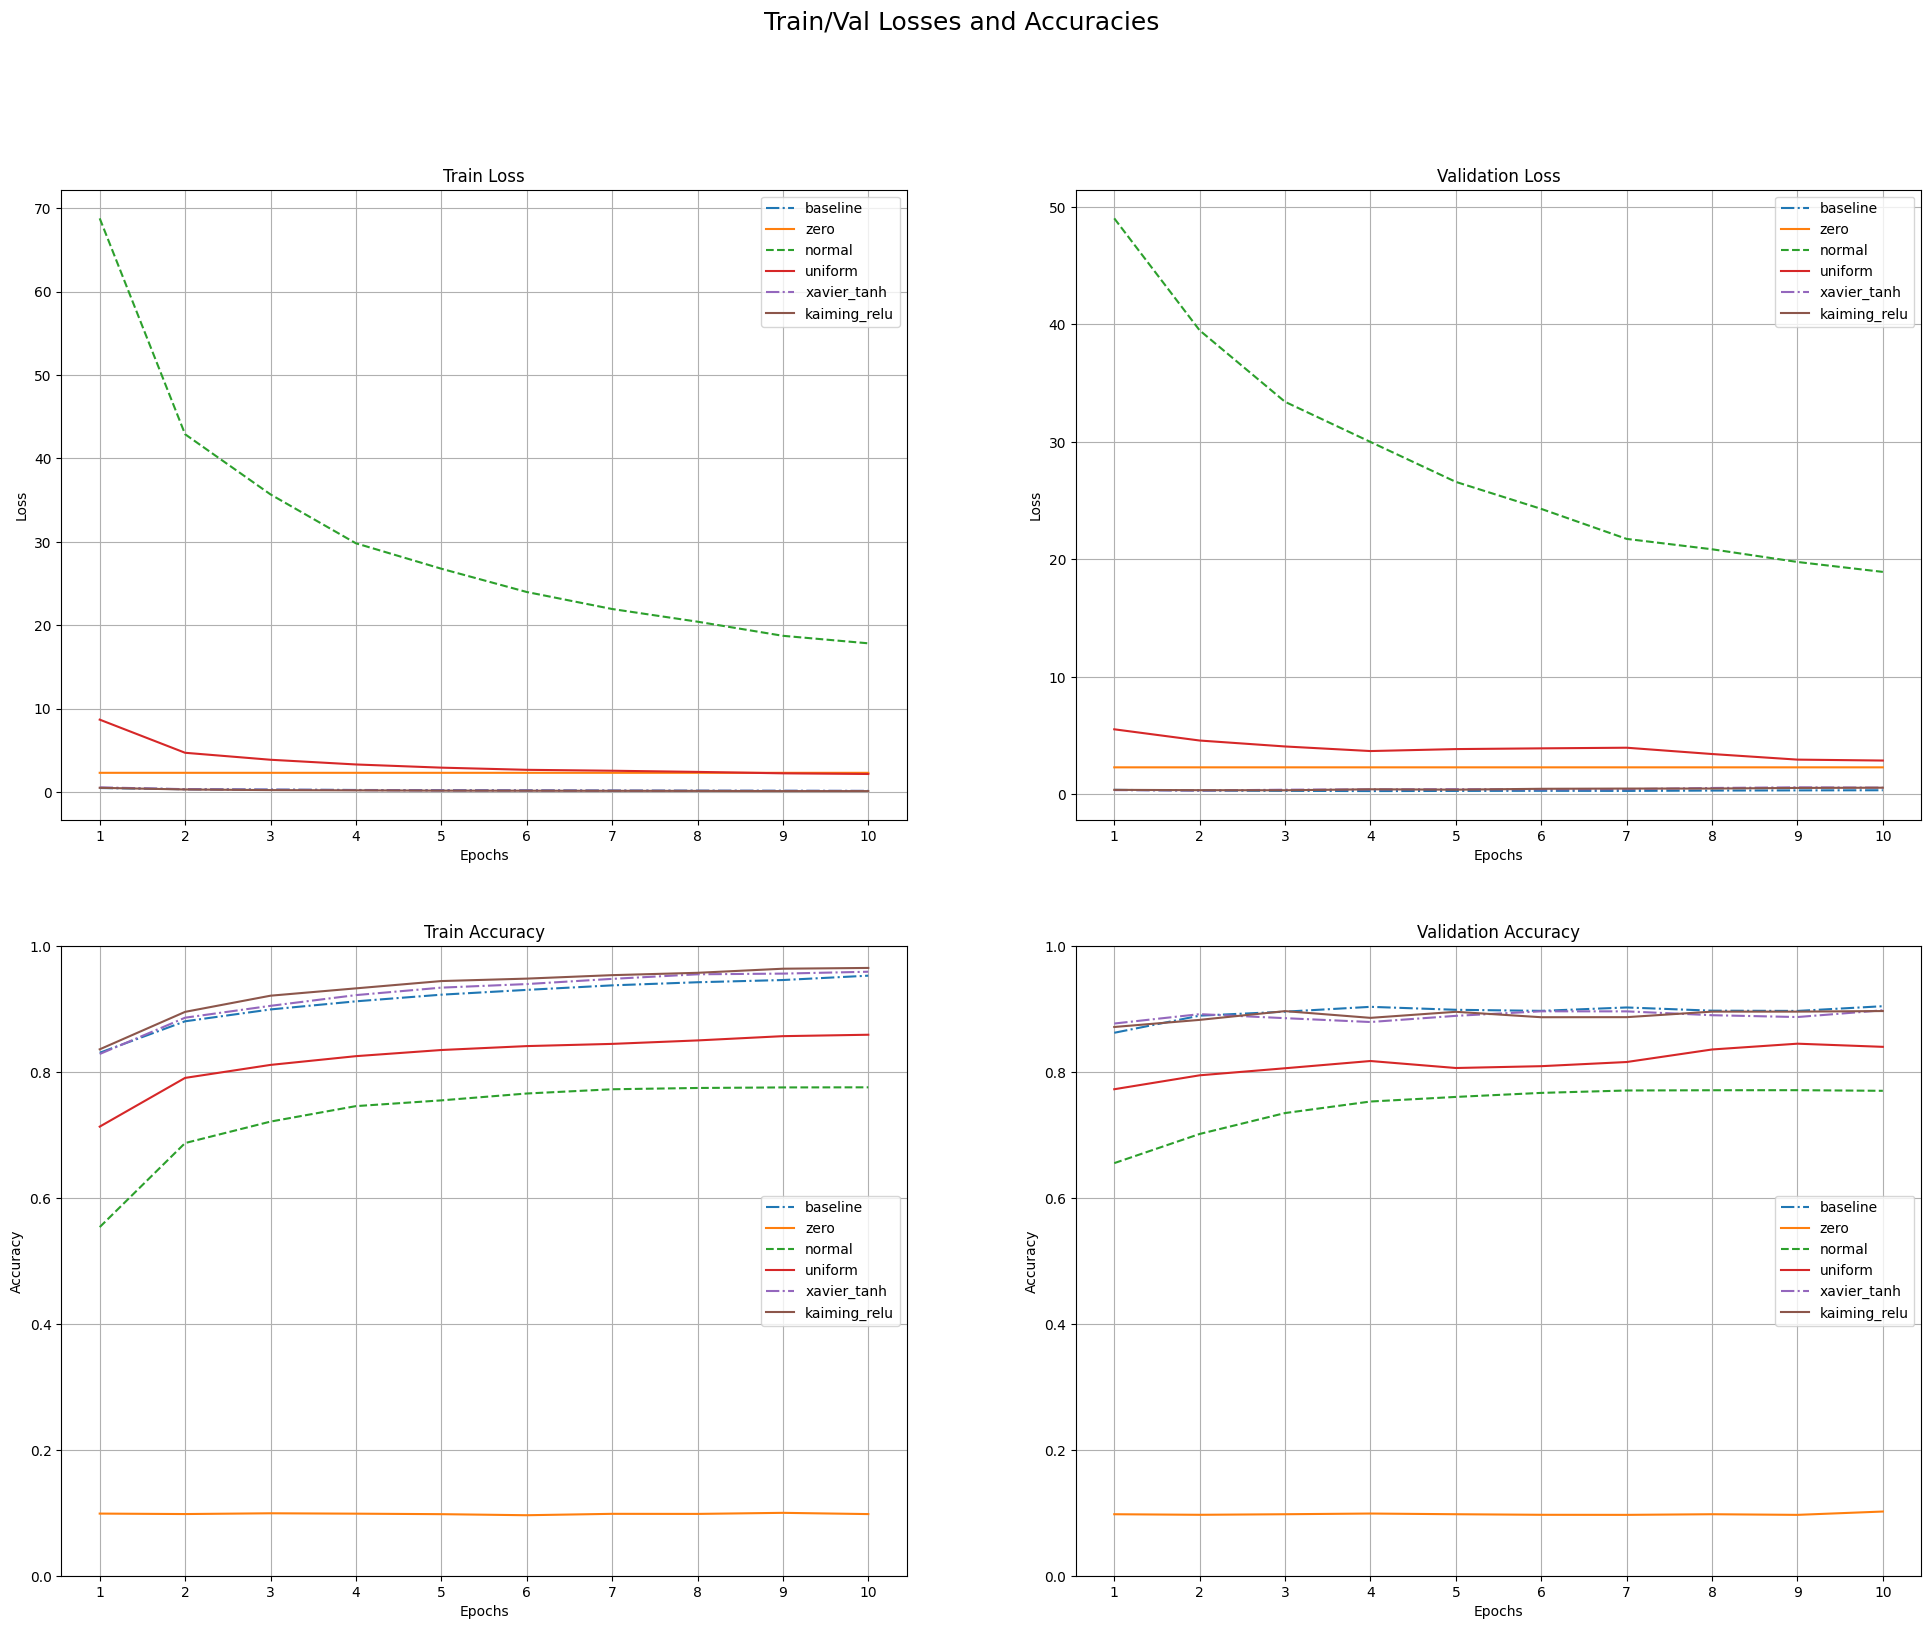

In [50]:
plot_loss_curves(n_epochs, results)

## Discussion
TODO